# Abstracts LDA

* Load the abstracts from the research articles identified in 10_research_papers notebook.
* Create a corpus with the abstracts
* Tokenize
* Apply single LDA
* Apply ensemble LDA

In [1]:
import pandas as pd
import os
import PyPDF2
from collections import defaultdict
from gensim import corpora
from gensim.models import LdaModel
from gensim.models import EnsembleLda
from gensim.parsing.preprocessing import preprocess_string

import numpy as np
from random import sample 

In [2]:
from matplotlib import pyplot as plt 

%matplotlib inline

## Load the abstracts 
* From the research articles on machine learning identified in 10_research_papers  notebook. Keep only the abstracts.
* Random sample 1000 papers

In [3]:
%%time

arxiv_ml_research = pd.read_csv('data/arxiv_ml_research.csv.zip')

CPU times: user 1.91 s, sys: 238 ms, total: 2.15 s
Wall time: 2.15 s


<timed exec>:1: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.


In [4]:
print(f"There are {arxiv_ml_research.shape[0]} research articles on machine learning in the dataset")

There are 207226 research articles on machine learning in the dataset


## Create a corpus with the abstracts

In [5]:
documents = arxiv_ml_research['abstract']

In [6]:
len(documents)

207226

### Random sample papers

In [7]:
sample_size = 50000
documents = sample(list(documents), sample_size)

### Tokenize

In [8]:
# remove common words and tokenize
texts = [
    preprocess_string(document)
    for document in documents
]

In [9]:
# remove words that appear only once
frequency = defaultdict(int)
for text in texts:
    for token in text:
        frequency[token] += 1

texts = [
    [token for token in text if frequency[token] > 1]
    for text in texts
]

In [10]:
dictionary = corpora.Dictionary(texts)
dictionary.filter_extremes(no_below=5, no_above=0.5)
corpus = [dictionary.doc2bow(text) for text in texts]

In [11]:
len(dictionary)

10986

## Apply single LDA
Simple 1-topic LDA

In [12]:
lda_model = LdaModel(corpus, id2word=dictionary, num_topics=1)
corpus_lda = lda_model[corpus]

In [13]:
lda_model.print_topics()

[(0,
  '0.011*"data" + 0.010*"method" + 0.008*"network" + 0.008*"base" + 0.008*"train" + 0.008*"gener" + 0.007*"perform" + 0.007*"algorithm" + 0.006*"task" + 0.006*"approach"')]

## Apply ensemble LDA

In [14]:
topic_model_class = LdaModel
ensemble_workers = 12
num_models = ensemble_workers * 2
distance_workers = 12
num_topics = 100
passes = 2

In [15]:
ensemble = EnsembleLda(
    corpus=corpus,
    id2word=dictionary,
    num_topics=num_topics,
    passes=passes,
    num_models=num_models,
    topic_model_class=topic_model_class,
    ensemble_workers=ensemble_workers,
    distance_workers=distance_workers
)

* Compute all the topics. In this setup: num_topics * num_workers
* Compute the stable topics

In [16]:
print(len(ensemble.ttda))
print(len(ensemble.get_topics()))

2400
20


In [17]:
ensemble.print_topics()

[(0,
  '0.318*"predict" + 0.017*"accur" + 0.013*"accuraci" + 0.011*"perform" + 0.011*"futur" + 0.011*"base" + 0.010*"data" + 0.009*"method" + 0.008*"approach" + 0.008*"result"'),
 (1,
  '0.205*"graph" + 0.049*"node" + 0.033*"network" + 0.030*"structur" + 0.026*"gnn" + 0.016*"edg" + 0.012*"topolog" + 0.012*"represent" + 0.012*"base" + 0.012*"method"'),
 (2,
  '0.208*"network" + 0.126*"neural" + 0.055*"deep" + 0.030*"train" + 0.022*"architectur" + 0.021*"layer" + 0.011*"convolut" + 0.010*"perform" + 0.009*"input" + 0.007*"result"'),
 (3,
  '0.110*"attack" + 0.109*"adversari" + 0.066*"robust" + 0.032*"perturb" + 0.022*"exampl" + 0.021*"vulner" + 0.020*"defens" + 0.019*"train" + 0.013*"input" + 0.012*"secur"'),
 (4,
  '0.267*"featur" + 0.040*"extract" + 0.037*"select" + 0.037*"method" + 0.018*"base" + 0.013*"differ" + 0.012*"perform" + 0.012*"dataset" + 0.010*"classif" + 0.010*"import"'),
 (5,
  '0.270*"gener" + 0.033*"train" + 0.031*"gan" + 0.019*"condit" + 0.018*"discrimin" + 0.016*"adve

## Tuning

In [18]:
shape = ensemble.asymmetric_distance_matrix.shape
shape

(2400, 2400)

In [19]:
without_diagonal = ensemble.asymmetric_distance_matrix[~np.eye(shape[0], dtype=bool)].reshape(shape[0], -1)
print(without_diagonal.min(), without_diagonal.mean(), without_diagonal.max())

0.0020265191659095683 0.8784940746861338 1.0


In [20]:
num_topics = []
perplexity = []
eps = []
range = np.linspace(without_diagonal.min(), without_diagonal.max(), num=25)
for val in range:
    ensemble.recluster(eps=val)
    topics = len(ensemble.get_topics())
    num_topics.append(topics)
    eps.append(val)
    if topics > 1:
        perplexity_eps = ensemble.log_perplexity(corpus)
        perplexity.append(perplexity_eps)
        print(f"eps: {val} stable number of topics: {topics}, perplexity: {perplexity_eps}")
    else:
        perplexity.append(-np.inf)


eps: 0.04360874753399667 stable number of topics: 11, perplexity: -8.880426096888636
eps: 0.08519097590208377 stable number of topics: 17, perplexity: -8.50630248221929
eps: 0.12677320427017086 stable number of topics: 29, perplexity: -7.920847826072437
eps: 0.16835543263825797 stable number of topics: 44, perplexity: -7.69725712753906
eps: 0.2099376610063451 stable number of topics: 54, perplexity: -7.695927354870469
eps: 0.25151988937443215 stable number of topics: 66, perplexity: -7.696852577200327
eps: 0.29310211774251926 stable number of topics: 73, perplexity: -7.709826975515015
eps: 0.3346843461106064 stable number of topics: 68, perplexity: -7.7273602564825685
eps: 0.3762665744786935 stable number of topics: 59, perplexity: -7.733396157989379
eps: 0.4178488028467806 stable number of topics: 43, perplexity: -7.693672565999984
eps: 0.45943103121486767 stable number of topics: 32, perplexity: -7.780319121682437
eps: 0.5010132595829548 stable number of topics: 18, perplexity: -7.94

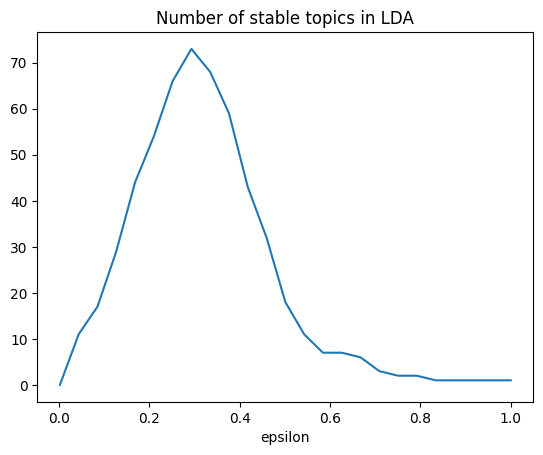

In [21]:
plt.plot(eps, num_topics)
plt.title("Number of stable topics in LDA")
plt.xlabel("epsilon")
plt.show()

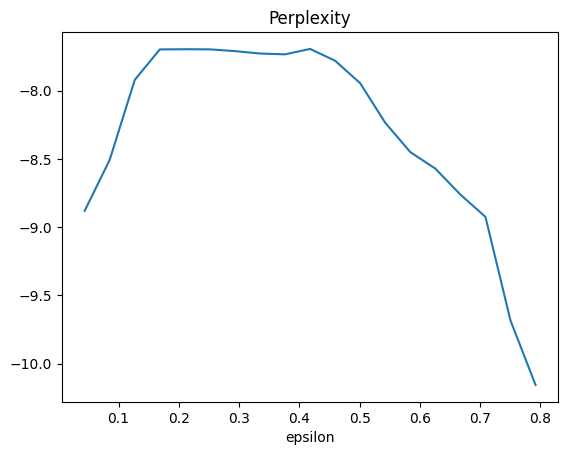

In [22]:
plt.plot(eps, perplexity)
plt.title("Perplexity")
plt.xlabel("epsilon")
plt.show()

In [23]:
eps[perplexity.index(max(perplexity))]

0.4178488028467806

In [24]:
eps = 0.25608691909620607
ensemble.recluster(eps=eps, min_samples=2, min_cores=2)
ensemble.print_topics()

[(89,
  '0.250*"map" + 0.037*"stream" + 0.035*"path" + 0.028*"tensor" + 0.023*"composit" + 0.017*"decomposit" + 0.015*"databas" + 0.015*"ontolog" + 0.013*"feedback" + 0.012*"locat"'),
 (41,
  '0.202*"instanc" + 0.054*"track" + 0.032*"calibr" + 0.030*"confid" + 0.019*"forc" + 0.019*"eeg" + 0.018*"subject" + 0.018*"dens" + 0.018*"team" + 0.015*"correl"'),
 (35,
  '0.198*"graph" + 0.049*"node" + 0.032*"network" + 0.028*"structur" + 0.026*"gnn" + 0.015*"edg" + 0.013*"topolog" + 0.012*"represent" + 0.012*"method" + 0.012*"base"'),
 (61,
  '0.138*"recommend" + 0.081*"item" + 0.058*"factor" + 0.030*"system" + 0.022*"user" + 0.021*"base" + 0.016*"transit" + 0.016*"collabor" + 0.011*"filter" + 0.011*"candid"'),
 (68,
  '0.202*"inform" + 0.025*"relat" + 0.021*"context" + 0.020*"extract" + 0.019*"knowledg" + 0.018*"mutual" + 0.016*"hierarch" + 0.014*"prefer" + 0.014*"level" + 0.014*"method"'),
 (88,
  '0.203*"rule" + 0.016*"sound" + 0.016*"base" + 0.014*"counterfactu" + 0.013*"failur" + 0.013*"pr